In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import joblib


In [2]:
df_model = pd.read_csv("../data/processed/bina_rent_model.csv")

print("Shape:", df_model.shape)
df_model.head()


Shape: (14113, 11)


,rooms,area_m2,floor_current,floor_total,price,district,floor_ratio,building_type_enc,is_baku,district_freq,district_target_enc
0,4,105,9,17,580,Xırdalan,0.529412,1,0,334,459.200599
1,1,50,17,17,549,20 Yanvar m.,1.000000,1,1,620,771.066129
2,3,80,3,5,699,Gənclik m.,0.600000,0,1,521,966.310940
3,2,50,1,2,800,Nizami m.,0.500000,0,1,752,1187.590426
4,3,90,9,12,750,Koroğlu m.,0.750000,1,1,43,915.581395


In [3]:
X = df_model.drop(columns=["price"])
y = df_model["price"]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


(11290, 10) (2823, 10)


In [ ]:
# Train-də district → price mean
district_mean = y_train.groupby(X_train["district"]).mean()

# Mapping
X_train["district_target_enc"] = X_train["district"].map(district_mean)
X_test["district_target_enc"] = X_test["district"].map(district_mean)

# Mean for districts not in the test set
X_test["district_target_enc"] = X_test["district_target_enc"].fillna(y_train.mean())

# String district is no longer needed
X_train.drop(columns=["district"], inplace=True)
X_test.drop(columns=["district"], inplace=True)


In [6]:
xgb_model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [7]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)


In [8]:
def eval_metrics(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

eval_metrics(y_train, y_pred_train, "Train XGB")
eval_metrics(y_test, y_pred_test, "Test XGB")


Train XGB → MAE: 105.34 | RMSE: 158.70 | R2: 0.878
Test XGB → MAE: 145.83 | RMSE: 224.87 | R2: 0.755


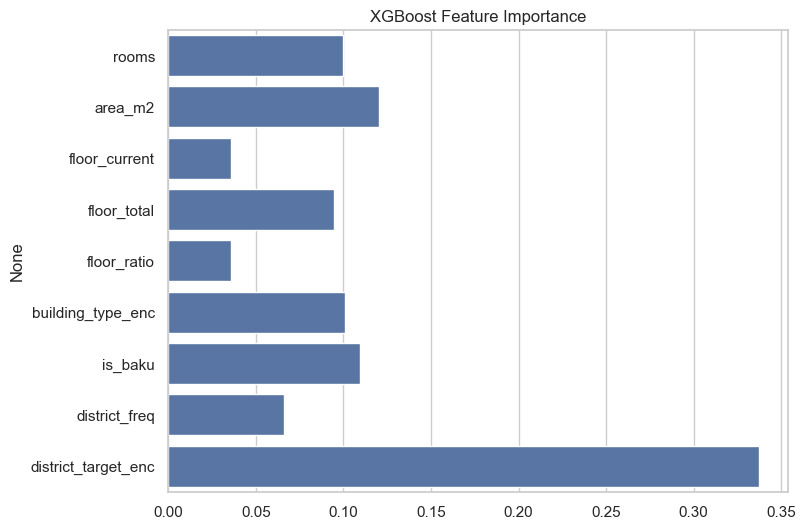

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(
    x=xgb_model.feature_importances_,
    y=X_train.columns
)
plt.title("XGBoost Feature Importance")
plt.show()


In [ ]:
# ===== FINAL MODEL (FULL DATA) =====

# Merge Train + Test

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# New model with the same hyperparameters
xgb_final = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

# Fit with FULL DATA

xgb_final.fit(X_full, y_full)

print("Final model trained with full data")


Final model full data ilə öyrədildi


In [ ]:
joblib.dump(xgb_final, "../models/xgboost_model.joblib")
print("Final XGBoost model saved")



Final XGBoost model saxlanıldı
